# Hair-plate axon connectivity analysis and visualization

### Brandon Pratt

Connectivity analysis for CxHP8 and other hair plates. User needs to request access to the FANC dataset.\
Dryad repository:

In [1]:
# Import libraries
import os
viz_method = 'vtk'

'''This is the EM specific package for querying the FANC EM data'''
from caveclient import CAVEclient

# import some of our favorite packages
import pandas as pd
import numpy as np
import os
import seaborn as sea
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
import pathlib

In [2]:
# save directory
save_dir = pathlib.Path.cwd().parent.joinpath('figures', 'raw', 'EM_figs')
save_path = str(save_dir)

In [3]:
# load dataset
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

In [4]:
# annotation tables
client.materialize.get_tables()

['wing_motor_neuron_table_v0',
 'soma_jan2022',
 'synapses_nov2022',
 'proofread_second_pass',
 'motor_neuron_table_v7',
 'somas_dec2022',
 'upstream_feco_axons',
 'downstream_feco_axons_v1',
 'synapse_regions_v1',
 'neuron_somas_dec2022',
 'topo_23b_table_v0',
 'downstream_10b_table_v0',
 'downstream_hair_plate_axon_table_v0',
 'peripheral_nerves',
 'grooming_command_like_neurons_v1',
 'feco_axons_v0',
 'glia_somas_dec2022',
 'gustatory_downstream_t1l',
 'proofread_by_andrewcook',
 'legcs_axons',
 'upstream_hair_plate_axon_table_v0',
 'neck_connective',
 'abdominal_sensory_axon_table_v0',
 'neurotransmitter_hemilineage_table',
 'hair_plate_table',
 'downstream_bristle_table_v0',
 'bristle_axon_table',
 'all_leg_motor_neuron_table_v0',
 'haltere_motor_neuron_table_v0',
 'nerve_bundle_fibers_v0',
 'right_to_left_t1_mn_bound2tag_v0',
 'neck_motor_neuron_table_v0',
 'proofreading_status_table_v0',
 'wing_premotor_v4',
 'bristle_post_sensory_neurons_v0',
 'downstream_cs_axons',
 'left_t1_l

### Load in hair-plate connectivity datasets

#### Hair-plate axons in T1L

In [5]:
# Hair Axons
hp_table = client.materialize.query_table('hair_plate_table')

# isolate just T1L hair-plates
t1l_hp_name = []
t1l_hp_id = []

for j in range(len(hp_table)):
    if hp_table['classification_system'].values[j][0:3] == 'T1L' and hp_table['cell_type'].values[j]!='Type A CS':
        t1l_hp_name.append(hp_table['cell_type'].values[j])
        t1l_hp_id.append(hp_table['pt_root_id'].values[j])

# sort names 
sort_idx = np.argsort(t1l_hp_name)
Lhp_names = np.array(t1l_hp_name)[sort_idx].tolist()
for j in range(len(Lhp_names)):
    if Lhp_names[j][0] =='U':
        Lhp_names[j] = Lhp_names[j].rsplit('_')[-1]
Lhp_ids = np.array(t1l_hp_id)[sort_idx].tolist()

print('Number of T1L Hair-Plates = ', len(Lhp_ids))

Number of T1L Hair-Plates =  33


#### Dowstream neurons of hair-plate axons

In [6]:
# downstream connectivity
downstream_table = client.materialize.query_table('downstream_hair_plate_axon_table_v0')

# arrays for storaging the relevant information
downstream_ids = []
downstream_hemilineage = []
downstream_cell_class = []

# extract unique ids and cell type information 
unique_neuron_ids = np.unique(downstream_table['pt_root_id'].values) # likely proofreading resulted in some of the fragments to be connected
for j in range(len(unique_neuron_ids)):
    neuron_idxs = np.where(downstream_table['pt_root_id'].values == unique_neuron_ids[j])[0]
    downstream_ids.append(unique_neuron_ids[j])
    if len(neuron_idxs) == 1: # unique neuron
        hemilineage, cell_type = downstream_table['cell_type'].values[neuron_idxs[0]].rsplit('_',1)
        downstream_hemilineage.append(hemilineage)
        downstream_cell_class.append(cell_type)
    else: # through proofreading, multiple fragements were combined
        temp_cell_type = []
        temp_hemilineage = []
        for i in neuron_idxs.tolist():
            hemilineage, cell_type = downstream_table['cell_type'].values[i].rsplit('_',1)
            temp_cell_type.append(cell_type)
            temp_hemilineage.append(hemilineage)
        
        # for cell-type choose the most popular one
        unqiue_cells, cell_counts = np.unique(temp_cell_type, return_counts=True)
        downstream_cell_class.append(unqiue_cells[np.argmax(cell_counts)])
        
        # for hemilinege see if one is present
        hemilineage_classification = np.array(temp_hemilineage)[np.array(temp_hemilineage) != 'unknown']
        if len(hemilineage_classification) > 0:
            downstream_hemilineage.append(hemilineage_classification[0])
        else:
            downstream_hemilineage.append('unknown')
            
print('Number of Downstream Partners = ', len(downstream_ids))

Number of Downstream Partners =  586


### Motor modules
#### Instead of showing motor neurons - show their functional role

In [7]:
'''Old table'''
# module_table = client.materialize.query_table('left_t1_mn_order_module_table_v1')
# mod_ids = module_table['pt_root_id'].values
# mod_names = module_table['tag2'].values

'''New table'''
module_table = client.materialize.query_table('leg_mn_module_reftable_v0')
mod_ids = module_table['pt_root_id'].values
mod_names = module_table['tag'].values

# motor neuron neuropil locations
mm_neuropil = client.materialize.query_table('leg_mn_neuropil_reftable_v0')
neuropil_assc = mm_neuropil['tag'].values

# isolate only t1l mms
mod_ids = mod_ids[neuropil_assc == 'left_t1']
mod_names = mod_names[neuropil_assc == 'left_t1']

# reference the hair-plate downstream table and replace hemilineage names
for j in range(len(downstream_ids)):
    if downstream_ids[j] in mod_ids.tolist():
        idx = np.where(mod_ids == downstream_ids[j])[0]
        downstream_hemilineage[j] = mod_names[idx][0]

#### Load in hemilineage neurotransmitter information

In [9]:
'''The user needs to point to where the file below is located'''
hm_class = pd.read_csv('LacinHLTable - HL table.csv') # cell type identity (hemilineages)

# inhibitory hemilineages
inhibitory_idxs = np.logical_or(hm_class['NT'].values.astype(str) == 'GABA', hm_class['NT'].values.astype(str) == 'Glu')
inhibitory_hms = hm_class['HL'][inhibitory_idxs].values.tolist()
print('Inhibitory Hemilineages = ', inhibitory_hms)

# excitatory hemilineages
excitatory_idxs = hm_class['NT'].values.astype(str) == 'Ach'
excitatory_hms = hm_class['HL'][excitatory_idxs].values.tolist()
print('Excitatory Hemilineages = ', excitatory_hms)

Inhibitory Hemilineages =  ['16B', '1B', '2A', '15B', '8A', '9A', '9B', '14A', '13A', '13B', '21A', '24B', '6A', '6B', '5B', '12B', '19A', '3B', '11B', '0A']
Excitatory Hemilineages =  ['1A', '10B', '18B', '17A', '4B', '7B', '8B', '20A', '22A', '12A', '19B', '3A', '11A', '23B']


In [10]:
# load in all hemilineage tables and cross reference table
# updated t1l premotor table
t1l_premotors = client.materialize.query_table('left_t1_local_premotor_table_v6')

# remove zeros from names
corrected_hm_ids = []
for j in t1l_premotors['classification_system'].values.tolist():
    if j[0] == '0':
        corrected_hm_ids.append(j[1::])
    else:
        corrected_hm_ids.append(j)
        
# create new premotor df with corrected names
premotor_info = t1l_premotors[['pt_root_id']]
premotor_info.insert(0, 'cell_type', corrected_hm_ids, True)

hm_table = client.materialize.query_table('neurotransmitter_hemilineage_table')
hm_info = hm_table[['cell_type', 'pt_root_id']]

DN_feco = client.materialize.query_table('downstream_feco_axons_v1')
DN_feco_info = DN_feco [['cell_type', 'pt_root_id']]

up_feco = client.materialize.query_table('upstream_feco_axons')
up_feco_info = up_feco [['cell_type', 'pt_root_id']]

DN_10b = client.materialize.query_table('downstream_10b_table_v0')
DN_10b_info = DN_10b [['cell_type', 'pt_root_id']]

# concatenate dataframes
cat_info = pd.concat([premotor_info, hm_info, DN_feco_info, up_feco_info, DN_10b_info], ignore_index=True)

# remove Nans, fragments, and unknowns
cat_info = cat_info[cat_info['cell_type'].values.astype(str) != 'nan']
cat_info =  cat_info[cat_info['cell_type'].values != 'fragment']
cat_info =  cat_info[cat_info['cell_type'].values != 'unknown']
cat_info =  cat_info[cat_info['cell_type'].values != 'sensory']
cat_info =  cat_info[cat_info['cell_type'].values != 'descending']
cat_info =  cat_info[cat_info['cell_type'].values != 'MN']
cat_info =  cat_info[cat_info['cell_type'].values != 'Rcore_']
cat_info =  cat_info[cat_info['cell_type'].values != '10B-like']
cat_info =  cat_info[cat_info['cell_type'].values != 'RVD']
cat_info =  cat_info[cat_info['cell_type'].values != 'ascending']

# remove repeated neurons
_, unique_idxs = np.unique(cat_info['pt_root_id'].values, return_index=True)
cat_info = cat_info.iloc[unique_idxs].reset_index(drop=True)

hm_cells = cat_info['cell_type'].values
e_i_u_type = np.zeros(len(hm_cells)).astype(str)
for j in range(len(hm_cells)):
    curr_hm = hm_cells[j]
    
    # inhibitory
    if curr_hm in inhibitory_hms:
        e_i_u_type[j] = 'I'
    # excitatory
    elif curr_hm in excitatory_hms:
        e_i_u_type[j] = 'E'
    else:  # Unknown
        e_i_u_type[j] = 'U'
        
# remove unknown neurons
cat_info['IEU_type'] = e_i_u_type
cat_info = cat_info[cat_info['IEU_type'] != 'U']
cat_info = cat_info.reset_index(drop = True)

In [11]:
hm_cell_ids = cat_info['pt_root_id'].values
hm_cell_classes = cat_info['cell_type'].values

downstream_EI = []
# reference the hair-plate downstream table and replace hemilineage names
for j in range(len(downstream_ids)):
    if downstream_ids[j] in hm_cell_ids.tolist():
        idx = np.where(hm_cell_ids == downstream_ids[j])[0]
        downstream_hemilineage[j] = hm_cell_classes[idx][0]
        downstream_EI.append(cat_info['IEU_type'].values[idx][0])
    else:
        downstream_EI.append('U')

In [12]:
# update hemilineage excitatory and inhibitory table for motor and sensory neurons
for j in range(len(downstream_cell_class)):
    if downstream_cell_class[j] == 'sensory neuron' or downstream_cell_class[j] == 'leg motor neuron':
        downstream_EI[j] = 'E'

#### Upstream neurons of hair-plate neurons

In [18]:
# upstream connectivity
upstream_table = client.materialize.query_table('upstream_hair_plate_axon_table_v0')

# arrays for storaging the relevant information
upstream_ids = []
upstream_hemilineage = []
upstream_cell_class = []

# extract unique ids and cell type information 
unique_neuron_ids = np.unique(upstream_table['pt_root_id'].values) # likely proofreading resulted in some of the fragments to be connected
for j in range(len(unique_neuron_ids)):
    neuron_idxs = np.where(upstream_table['pt_root_id'].values == unique_neuron_ids[j])[0]
    upstream_ids.append(unique_neuron_ids[j])
    if len(neuron_idxs) == 1: # unique neuron
        hemilineage, cell_type = upstream_table['cell_type'].values[neuron_idxs[0]].rsplit('_',1)
        upstream_hemilineage.append(hemilineage)
        upstream_cell_class.append(cell_type)
    else: # through proofreading, multiple fragements were combined
        temp_cell_type = []
        temp_hemilineage = []
        for i in neuron_idxs.tolist():
            hemilineage, cell_type = upstream_table['cell_type'].values[i].rsplit('_',1)
            temp_cell_type.append(cell_type)
            temp_hemilineage.append(hemilineage)
        
        # for cell-type choose the most popular one
        unqiue_cells, cell_counts = np.unique(temp_cell_type, return_counts=True)
        upstream_cell_class.append(unqiue_cells[np.argmax(cell_counts)])
        
        # for hemilinege see if one is present
        hemilineage_classification = np.array(temp_hemilineage)[np.array(temp_hemilineage) != 'unknown']
        if len(hemilineage_classification) > 0:
            upstream_hemilineage.append(hemilineage_classification[0])
        else:
            upstream_hemilineage.append('unknown')
            
print('Number of Upstream Partners = ', len(upstream_ids))

Number of Upstream Partners =  92


In [19]:
# update upstream sensory neurons to best guess identites
for j in range(len(upstream_ids)):
    if upstream_ids[j] in Lhp_ids:
        idx = np.where(np.array(Lhp_ids) == upstream_ids[j])[0][0]
        upstream_hemilineage[j] = np.array(Lhp_names)[idx]

In [20]:
hm_cell_ids = cat_info['pt_root_id'].values
hm_cell_classes = cat_info['cell_type'].values

upstream_EI = []
# reference the hair-plate upstream table and replace hemilineage names
for j in range(len(upstream_ids)):
    if upstream_ids[j] in hm_cell_ids.tolist():
        idx = np.where(hm_cell_ids == upstream_ids[j])[0]
        upstream_hemilineage[j] = hm_cell_classes[idx][0]
        upstream_EI.append(cat_info['IEU_type'].values[idx][0])
    else:
        upstream_EI.append('U')
        
# update hemilineage excitatory and inhibitory table for motor and sensory neurons
for j in range(len(upstream_cell_class)):
    if upstream_cell_class[j] == 'sensory neuron':
        upstream_EI[j] = 'E'

### Query downstream connectivity of each T1L hair-plate axon

In [13]:
syn_threshold = 3
downstream_connectivity_matrix = np.zeros((len(Lhp_ids), len(downstream_ids)))
sensory_df = client.materialize.synapse_query(pre_ids = Lhp_ids) # query T1L HP connectivity
neuron_cnt = -1
dwn_syn_counts = np.zeros(len(Lhp_ids))

for j in Lhp_ids: 
    neuron_cnt += 1
    
    # hair plate specific data frame sorted by the strongest synapse
    dwn_df = sensory_df[sensory_df['pre_pt_root_id'] == j]
    dwn_synapses = dwn_df .groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    dwn_syn_counts[neuron_cnt] = np.sum(dwn_synapses['number_of_synapses'].values)
    dwn_synapses = dwn_synapses[dwn_synapses['number_of_synapses'] > syn_threshold]
    
    # iterate downstream neurons and fill in synapses counts into connectivity table
    dw_cnt = -1
    for dw_neuron in downstream_ids:
        dw_cnt += 1
        if dw_neuron in dwn_synapses['post_pt_root_id'].values.tolist():
            n_idx = np.where(dwn_synapses['post_pt_root_id'].values==dw_neuron)[0]
            downstream_connectivity_matrix[neuron_cnt, dw_cnt] = dwn_synapses['number_of_synapses'].values[n_idx]
            
print('downstream matrix shape = ', downstream_connectivity_matrix.shape)

downstream matrix shape =  (33, 586)


In [14]:
# filter out downstream neurons if they don't recieve any output synapes from T1L hps
syn_filt_idxs = np.where(np.sum(downstream_connectivity_matrix, axis =0)!=0)[0]

# Filter relevants downstream neuron arrays
downstream_ids = np.array(downstream_ids)[syn_filt_idxs].tolist()
downstream_hemilineage = np.array(downstream_hemilineage)[syn_filt_idxs].tolist()
downstream_EI = np.array(downstream_EI)[syn_filt_idxs].tolist()
downstream_connectivity_matrix = downstream_connectivity_matrix[:,syn_filt_idxs]
downstream_cell_class = np.array(downstream_cell_class)[syn_filt_idxs].tolist()

In [15]:
# convert unidentified hps into actual T1L HPs
for j in range(len(downstream_ids)):
    if downstream_ids[j] in Lhp_ids:
        idx = np.where(np.array(Lhp_ids) == downstream_ids[j])[0]
        downstream_hemilineage[j] = np.array(Lhp_names)[idx][0]

In [16]:
print(f'filter DN mat size = {downstream_connectivity_matrix.shape}')

filter DN mat size = (33, 491)


### CXHP8 specific connectivity

In [17]:
cxhp8_partners_syns = np.sum(downstream_connectivity_matrix[7:15,:], axis =0) 
cxhp8_locs = np.where(cxhp8_partners_syns >0)[0]
cxhp8_partners_syns_filt = cxhp8_partners_syns[cxhp8_locs]
partner_ids = np.array(downstream_ids)[cxhp8_locs]

# determine the percent of them that are premotor or motor neurons
tot_synapses = 0
mn_syn_cnt = 0
pre_mn_cnt = 0
other_cnt = 0
for j in range(len(partner_ids)):
    curr_syn = cxhp8_partners_syns_filt[j]
    tot_synapses += curr_syn
    if partner_ids[j] in premotor_info['pt_root_id'].values.tolist(): 
        pre_mn_cnt += curr_syn
    elif partner_ids[j] in mod_ids.tolist():
        mn_syn_cnt += curr_syn
    else:
        other_cnt += curr_syn
    
    

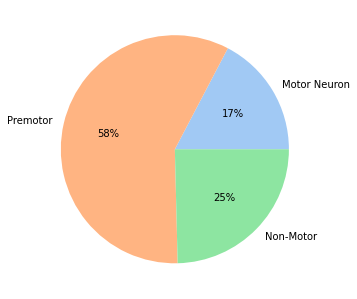

In [18]:
# make piechart showing the difference
fig = plt.figure(1, figsize = [5,5])
labels = ['Motor Neuron', 'Premotor', 'Non-Motor']

data = [mn_syn_cnt/tot_synapses, pre_mn_cnt/tot_synapses, other_cnt/tot_synapses]

#define Seaborn color palette to use
colors = sea.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.tight_layout()
plt.show()

# fig.savefig(save_path+'cxhp8_motor.png', dpi=300)
# fig.savefig(save_path+'cxhp8_motor.pdf', dpi=300)

In [28]:
hp_idxs = np.where(np.array(Lhp_names)=='CoHP8')[0]
    
# plot hps
y = np.std(dwn_syn_counts[hp_idxs])

print('average_hp_synapses', y)

average_hp_synapses 481.50816127559045


#### CxHP8 motor neuron connectivity

In [21]:
# sort motor modules (~MNs) along the proximal-distal axis of the leg
# mm_order = ['coxa_posterior', 'coxa_promotion', 'coxa_rotator_adductor', 'trochanter_flex', 
#            'trochanter_extend', 'femur_reduct', 'tibia_ta_flex_A', 'tibia_ta_flex_B', 'tibia_ta_flex_C',
#            'tibia_extend', 'tarsus_depressor_ventralU']

'''New naming scheme'''
mm_order = ['coxa_posterior', 'coxa_anterior', 'coxa_promote',
       'coxa_rotate_adduct', 'trochanter_extend', 'trochanter_flex', 'femur_reduct', 
       'tibia_extend','tibia_ta_flex_A', 'tibia_ta_flex_B', 'tibia_ta_flex_C',
       'tarsus_depress_medial', 'tarsus_depress_ventralU','ltm_A', 'ltm_B']
mm_idxs = np.where(np.array(downstream_cell_class) == 'leg motor neuron')[0]
mm_names = np.array(downstream_hemilineage)[mm_idxs]

for j in range(len(mm_order)):
    curr_mm_ids = np.where(np.array(downstream_hemilineage) == mm_order[j])[0]
    if len(curr_mm_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_mm_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    
        if j ==0:
            id_order = curr_mm_ids[clustered_order]
            mm_name_store = np.repeat(mm_order[j], len(curr_mm_ids))
        else:
            id_order = np.concatenate((id_order, curr_mm_ids[clustered_order]))
            mm_name_store = np.concatenate((mm_name_store, np.repeat(mm_order[j], len(curr_mm_ids))))
    else:
        if j ==0:
            id_order = curr_mm_ids
            mm_name_store = np.repeat(mm_order[j], len(curr_mm_ids))
        else:
            id_order = np.concatenate((id_order, curr_mm_ids))
            mm_name_store = np.concatenate((mm_name_store, np.repeat(mm_order[j], len(curr_mm_ids))))

In [22]:
mm_mat = downstream_connectivity_matrix[7:15, id_order]

# remove columns that don't have connectivity
filt_idxs = np.where(np.sum(mm_mat, axis = 0)> 0)[0]
mm_mat_filt = mm_mat[:, filt_idxs]
filt_mm_name = mm_name_store[filt_idxs] 
mm_mat_filt.shape

(8, 11)

### Just CxHP8

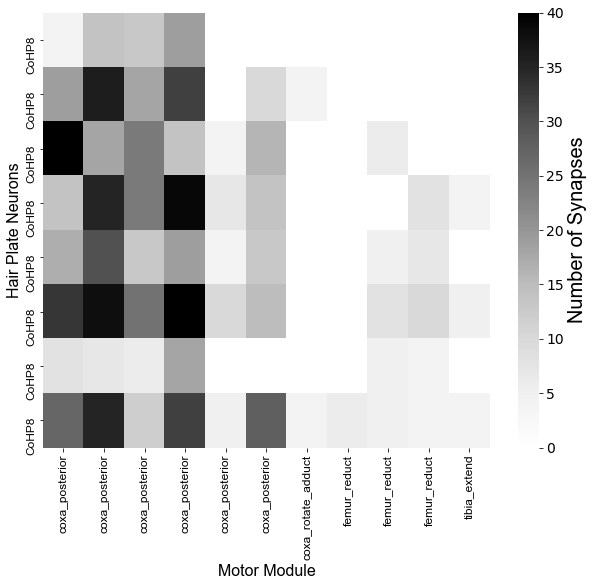

In [23]:
# visualize connectivity matrix
fig = plt.figure(1, figsize = [10,8])
ax = sea.heatmap(mm_mat_filt, xticklabels=filt_mm_name.tolist(), yticklabels=np.array(Lhp_names)[7:15].tolist(), cmap='Greys', vmin=0, vmax=40) #parula_map 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Motor Module', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.show()
# fig.savefig(save_dir.joinpath('02232025_cxhp8_motor_module_connectivity_matrix.png'), dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_dir.joinpath('02232025_cxhp8_motor_module_connectivity_matrix.pdf'), dpi = 300, bbox_inches = 'tight')

### All Hair Plates

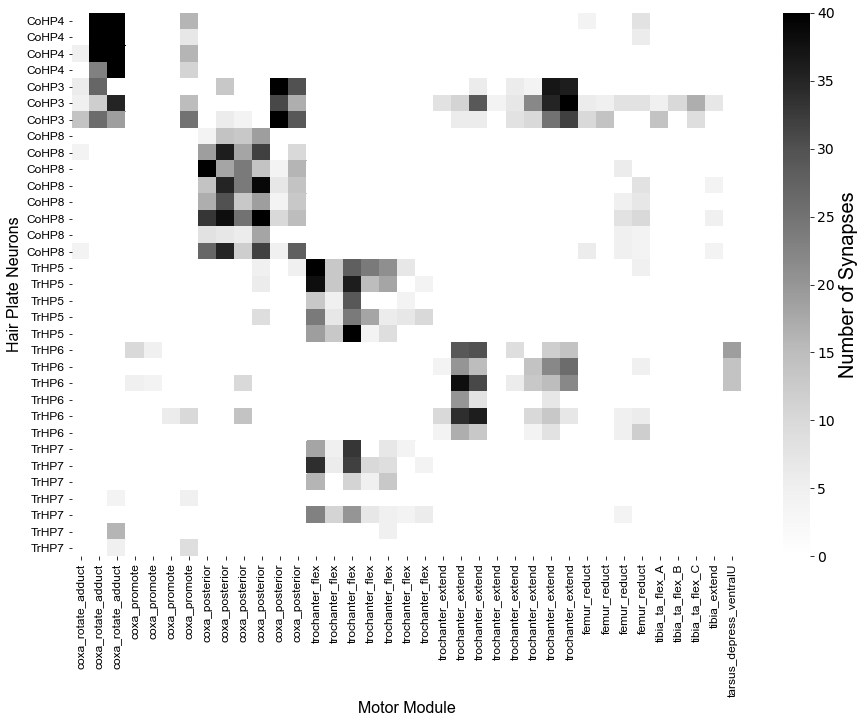

In [24]:
'''New naming scheme that are based on Sankey plots'''
mm_order = ['coxa_anterior', 'coxa_rotate_adduct','coxa_promote', 'coxa_posterior', 'trochanter_flex', 'trochanter_extend', 
            'femur_reduct', 'tibia_ta_flex_A', 'tibia_ta_flex_B', 
            'tibia_ta_flex_C', 'tibia_extend','tarsus_depress_medial', 'tarsus_depress_ventralU',
            'ltm_A', 'ltm_B']
mm_idxs = np.where(np.array(downstream_cell_class) == 'leg motor neuron')[0]
mm_names = np.array(downstream_hemilineage)[mm_idxs]

for j in range(len(mm_order)):
    curr_mm_ids = np.where(np.array(downstream_hemilineage) == mm_order[j])[0]
    if len(curr_mm_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_mm_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    
        if j ==0:
            id_order = curr_mm_ids[clustered_order]
            mm_name_store = np.repeat(mm_order[j], len(curr_mm_ids))
        else:
            id_order = np.concatenate((id_order, curr_mm_ids[clustered_order]))
            mm_name_store = np.concatenate((mm_name_store, np.repeat(mm_order[j], len(curr_mm_ids))))
    else:
        if j ==0:
            id_order = curr_mm_ids
            mm_name_store = np.repeat(mm_order[j], len(curr_mm_ids))
        else:
            id_order = np.concatenate((id_order, curr_mm_ids))
            mm_name_store = np.concatenate((mm_name_store, np.repeat(mm_order[j], len(curr_mm_ids))))



# visualize connectivity matrix
# reorder connectivity matrix so that CxHP4 comes before CxHP3
swap_idx = np.arange(downstream_connectivity_matrix.shape[0])
swap_idx[0:4] = np.array([3,4,5,6])
swap_idx[4:7] = np.array([0,1,2])
swapped_downstream_connectivity_matrix = downstream_connectivity_matrix[swap_idx,:] # reorder so that CxHP4 comes first

# filter the hair plate to motor module
swapped_mm_mat = swapped_downstream_connectivity_matrix[:, id_order]
swapped_filt_idxs = np.where(np.sum(swapped_mm_mat, axis = 0)> 0)[0]
swapped_mm_mat_filt = swapped_mm_mat[:, swapped_filt_idxs]
filt_mm_name = mm_name_store[swapped_filt_idxs] 

# plot direct motor neuron connectivity
fig = plt.figure(1, figsize = [15,10])
ax = sea.heatmap(swapped_mm_mat_filt, xticklabels=filt_mm_name.tolist(), yticklabels=np.array(Lhp_names)[swap_idx].tolist(), cmap='Greys', vmin=0, vmax=40) #parula_map 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Motor Module', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.show()
# fig.savefig(save_dir.joinpath('03302025_hp_motor_module_connectivity_matrix.png'), dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_dir.joinpath('03302025_hp_motor_module_connectivity_matrix.pdf'), dpi = 300, bbox_inches = 'tight')

### plot the number of input synapes of CxHP8 onto motor modules

In [31]:
# compute the average fraction of direct synapses of CxHP8 neurons onto motor modules
unique_mm = np.unique(mod_names) 
tot_mm_syns = np.sum(mm_mat, axis=1)
mean_mm_syn = np.zeros(unique_mm.shape[0])
std_mm_syn = np.zeros(unique_mm.shape[0])

for i, mm in enumerate(unique_mm):
    # all mm that cxhp8 synapes onto
    if mm in mm_name_store:
        idxs = np.where(mm_name_store == mm)[0]
        fraction_mm_output = np.sum(mm_mat[:, idxs], axis=1)/tot_mm_syns   # synapses of all mns
        mean_mm_syn[i] = np.mean(fraction_mm_output)
        std_mm_syn[i] = np.std(fraction_mm_output)
        
# rank values
mm_sort_idxs = np.argsort(mean_mm_syn)[::-1]
mm_names_sorted = unique_mm[mm_sort_idxs]
mean_mm_syn_sorted = mean_mm_syn[mm_sort_idxs]
std_mm_syn_sorted = std_mm_syn[mm_sort_idxs]

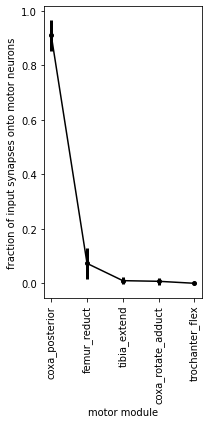

In [32]:
# plot fraction CxHP8 output
fig = plt.figure(1, figsize=[3,6])
plt.errorbar(np.arange(unique_mm.shape[0])[0:5], mean_mm_syn_sorted[0:5], yerr=std_mm_syn_sorted[0:5], color='k', linewidth=1.5, marker='.', markersize=8, elinewidth=3)
plt.xticks(np.arange(unique_mm.shape[0])[0:5], mm_names_sorted[0:5], rotation=90)
plt.ylabel('fraction of input synapses onto motor neurons')
plt.xlabel('motor module')
plt.tight_layout()
plt.show()

fig.savefig(save_dir.joinpath('CxHP_input_motor_modules.png'), dpi=200)
fig.savefig(save_dir.joinpath('CxHP_input_motor_modules.pdf'), dpi=200)

#### CxHP8 premotor connectivity

In [25]:
# correct cell class labels
downstream_cell_class[np.where(np.array(downstream_cell_class)=='local?')[0][0]] = 'orphan fragment'

# # remove unknown cell class because it is a result of T1R being damaged
# downstream_ids = np.array(downstream_ids)[np.array(downstream_cell_class)!='unknown'].tolist()
# downstream_hemilineage = np.array(downstream_hemilineage)[np.array(downstream_cell_class)!='unknown'].tolist()
# downstream_EI = np.array(downstream_EI)[np.array(downstream_cell_class)!='unknown'].tolist()
# downstream_connectivity_matrix = downstream_connectivity_matrix[:,np.array(downstream_cell_class)!='unknown']
# downstream_cell_class = np.array(downstream_cell_class)[np.array(downstream_cell_class)!='unknown'].tolist()

In [26]:
# split local into local premotor and local non-premotor
for j in range(len(downstream_ids)):
    if downstream_ids[j] in premotor_info['pt_root_id'].values.tolist():
        idx = np.where(premotor_info['pt_root_id'].values == downstream_ids[j])[0]
        downstream_cell_class[j] = 'local premotor'

In [27]:
np.unique(downstream_cell_class)

array(['ascending', 'descending', 'glia', 'intersegmental',
       'leg motor neuron', 'local', 'local premotor', 'orphan fragment',
       'sensory neuron'], dtype='<U16')

In [28]:
# seperate inhibitory and excitatory premotor neurons
syn_threshold = 3
# inhibitory
iin_order = ['6A', '8A', '9A', '12B', '13A', '13B', '14A', '16B', '19A', '21A']
iin_pre_idxs = np.where(np.logical_and(np.array(downstream_cell_class) == 'local premotor', np.array(downstream_EI) == 'I') == True)[0]
iin_names = np.array(downstream_hemilineage)[iin_pre_idxs]

for j in range(len(iin_order)):
    curr_ids = iin_pre_idxs[np.where(np.array(iin_names) == iin_order[j])[0]]
    if len(curr_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers

        if j ==0:
            iin_id_order = curr_ids[clustered_order]
            iin_name_store = np.repeat(iin_order[j], len(curr_ids))
            cnt = 1
        else:
            iin_id_order = np.concatenate((iin_id_order, curr_ids[clustered_order]))
            iin_name_store = np.concatenate((iin_name_store, np.repeat(iin_order[j], len(curr_ids))))
    else:
        if j ==0:
            iin_id_order = curr_ids
            iin_name_store = np.repeat(iin_order[j], len(curr_ids))
            cnt = 1
        else:
            iin_id_order = np.concatenate((iin_id_order, curr_ids))
            iin_name_store = np.concatenate((iin_name_store, np.repeat(iin_order[j], len(curr_ids))))


# excitatory
ein_order = ['1A', '3A', '4B', '7B', '17A', '19B', '20A', '22A', '23B']
ein_pre_idxs = np.where(np.logical_and(np.array(downstream_cell_class) == 'local premotor', np.array(downstream_EI) == 'E') == True)[0]
ein_names = np.array(downstream_hemilineage)[ein_pre_idxs]
for j in range(len(ein_order)):
    curr_ids = ein_pre_idxs[np.where(np.array(ein_names) == ein_order[j])[0]]
    if len(curr_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers

        if j ==0:
            ein_id_order = curr_ids[clustered_order]
            ein_name_store = np.repeat(ein_order[j], len(curr_ids))
            cnt = 1
        else:
            ein_id_order = np.concatenate((ein_id_order, curr_ids[clustered_order]))
            ein_name_store = np.concatenate((ein_name_store, np.repeat(ein_order[j], len(curr_ids))))
    else:
        if j ==0:
            ein_id_order = curr_ids
            ein_name_store = np.repeat(ein_order[j], len(curr_ids))
            cnt = 1
        else:
            ein_id_order = np.concatenate((ein_id_order, curr_ids))
            ein_name_store = np.concatenate((ein_name_store, np.repeat(ein_order[j], len(curr_ids))))

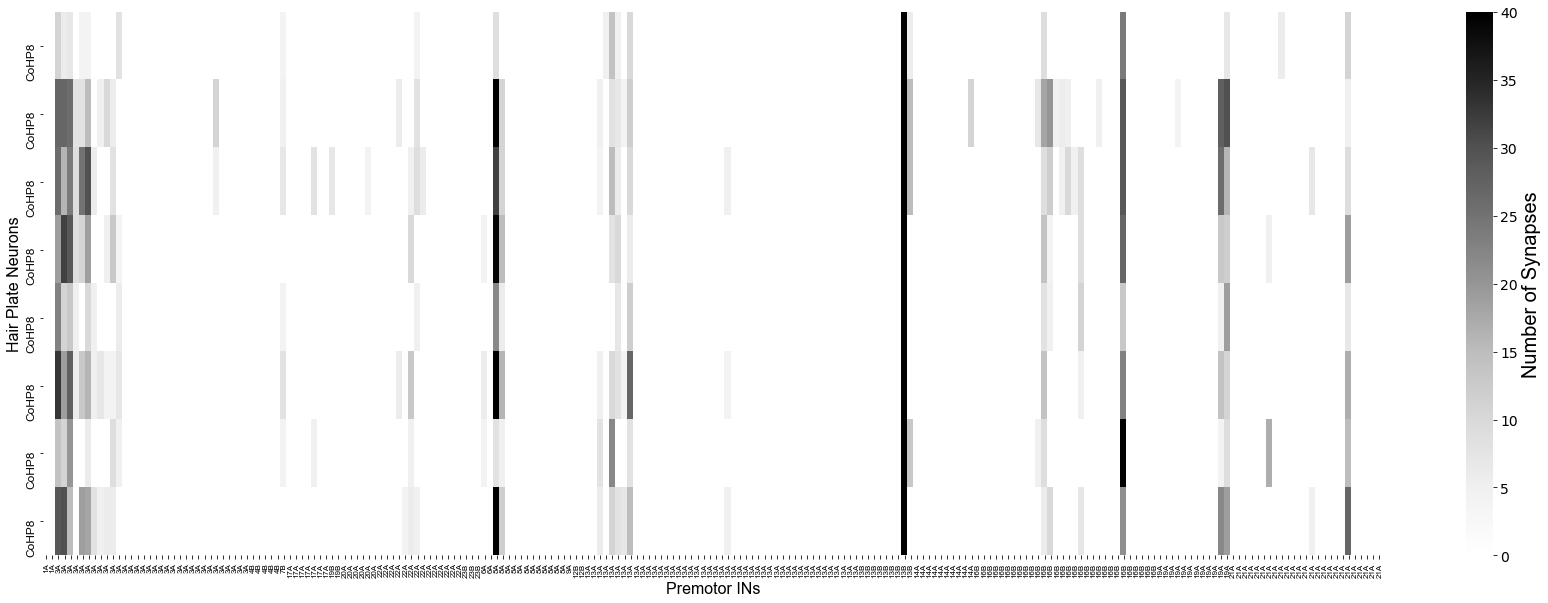

In [30]:
# combine ein and iin matrices and visualize
cat_in_ids = np.concatenate((ein_id_order, iin_id_order))
cat_in_names = np.concatenate((ein_name_store, iin_name_store))

# extract out motor module connectivity matrix
in_mat = downstream_connectivity_matrix[7:15, cat_in_ids]   # set rows to all for premotor connectivity of every hp

# visualize connectivity matrix
fig = plt.figure(1, figsize = [30,10])
ax = sea.heatmap(in_mat, xticklabels = cat_in_names.tolist(), yticklabels=np.array(Lhp_names)[7:15].tolist(), cmap='Greys',vmin=0, vmax=40) #
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Premotor INs', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 8, fontname = 'Arial')
plt.show()

# fig.savefig(save_dir.joinpath('02232025_cxhp8_premotor_connectivity_matrix.png'), dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_dir.joinpath('02232025_cxhp8_premotor_connectivity_matrix.pdf'), dpi = 300, bbox_inches = 'tight')

### Number of output synapses per hair-plate class

In [45]:
save_path = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/hairplates_2024/figures/raw/EM_figs/'

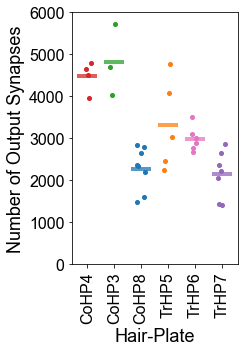

In [46]:
# unique hair-plates
hp_types = np.array(['CoHP4', 'CoHP3', 'CoHP8', 'TrHP5', 'TrHP6', 'TrHP7'])
hp_colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:pink', 'tab:purple']
fig = plt.figure(1, figsize = [3.5,5])
w = 0.3
for j in range(len(hp_types)):
    # find hps 
    hp_idxs = np.where(np.array(Lhp_names)==hp_types[j])[0]
    
    # plot hps
    x = j*np.ones(len(hp_idxs)) + np.random.choice([-1,1], size=len(hp_idxs))*np.random.uniform(low=0.0, high=0.15, size=len(hp_idxs))
    y = dwn_syn_counts[hp_idxs]
#     plt.plot(x,y, marker ='.', linestyle = 'none', markersize = 8, color = 'gray', alpha = 0.75, zorder = 10)
    plt.plot(x,y, marker ='.', linestyle = 'none', markersize = 8, color = hp_colors[j], alpha = 1, zorder = 1)
    
    # plot average
#     plt.plot(np.array([j-w, j+w]), np.array([np.mean(y), np.mean(y)]), color = 'black', linewidth = 4, zorder = 1)
    plt.plot(np.array([j-w, j+w]), np.array([np.mean(y), np.mean(y)]), color = hp_colors[j], linewidth = 4, zorder = 10, alpha = 0.75)

plt.xticks(np.arange(0, len(hp_types)), hp_types, fontsize = 16, rotation = 90, fontname = 'Arial')
plt.yticks(fontsize = 16, fontname = 'Arial')
plt.xlabel('Hair-Plate', fontsize = 18, fontname = 'Arial')
plt.ylabel('Number of Output Synapses', fontsize = 18, fontname = 'Arial')
plt.ylim([0,6000])
plt.tight_layout()
plt.show()
# fig.savefig(save_path+'hairplate_output_synapses.png', dpi=300)
# fig.savefig(save_path+'hairplate_output_synapses.svg', dpi=300)



#### Top cell-classes downstream of hair-plate neurons

In [47]:
# find the proportion of hair-plate input onto each unique cell class
cell_classes = np.unique(downstream_cell_class)
proportion_input = np.zeros((downstream_connectivity_matrix.shape[0], len(cell_classes))) # n hair-plates x n cell classes
for i in range(len(Lhp_ids)): # hps
    dwn_cells = np.array(downstream_cell_class)[downstream_connectivity_matrix[i,:]>0]
    for j in range(len(cell_classes)): # cell classes
        proportion_input[i,j] = len(np.where(dwn_cells==cell_classes[j])[0])
    proportion_input[i,:] = proportion_input[i,:]/np.sum(proportion_input[i,:])
        
# average downstream proportionality
ave_dwn_cell_classes = np.mean(proportion_input,axis=0)
sorting_idxs = np.flip(np.argsort(ave_dwn_cell_classes))
ave_cell_classes_sorted = ave_dwn_cell_classes[sorting_idxs]
cell_classes_sorted = cell_classes[sorting_idxs]
proportion_syn_sorted = proportion_input[:,sorting_idxs]
std_cell_classes = np.std(proportion_syn_sorted, axis=0)#1.96*(np.std(proportion_syn_sorted, axis=0)/np.sqrt(proportion_syn_sorted.shape[0]))

In [39]:
# plot the fraction of synapses onto downstream cell classes
hps = np.array(['CoHP4', 'CoHP3', 'CoHP8', 'TrHP5', 'TrHP6', 'TrHP7'])
hp_colors = ['tab:red', 'tab:green', 'tab:blue', 'tab:orange', 'tab:pink', 'tab:purple']
fig = plt.figure(1, figsize = [3,6])
for j in range(len(hps)):
    # find hps 
    hp_idxs = np.where(np.array(Lhp_names)==hps[j])[0]
    
    # plot hps
#     for i in range(len(hp_idxs)):
#         x = np.arange(1, proportion_syn_sorted.shape[1]+1) + np.random.choice([-1,1])*np.random.uniform(low=0.0, high=0.15)
#         y = proportion_syn_sorted[hp_idxs[i],:] 
#         plt.plot(x,y, marker ='.', linestyle = 'none', markersize = 8, color = hp_colors[j], alpha = 0.8, zorder =5)
    
    # plot average
#     plt.plot(np.arange(1, proportion_syn_sorted.shape[1]+1),np.mean(proportion_syn_sorted[hp_idxs,:], axis =0), color = hp_colors[j], linewidth = 1.25, label = hps[j])
    
    plt.plot(np.arange(1, proportion_syn_sorted.shape[1]+1),np.mean(proportion_syn_sorted[hp_idxs,:], axis =0), color = hp_colors[j], linestyle = 'none', marker = '.', markersize = 10, label = hps[j], alpha = 1)
    
# plot total mean       
plt.errorbar(np.arange(1, proportion_syn_sorted.shape[1]+1)+0.15, ave_cell_classes_sorted, yerr=std_cell_classes, color ='black', markersize = 15, linewidth = 3, zorder =1)
plt.xticks(np.arange(1, proportion_syn_sorted.shape[1]+1), cell_classes_sorted, fontsize = 16, rotation = 90, fontname = 'Arial')
plt.yticks(fontsize = 16, fontname = 'Arial')
plt.xlabel('Cell Class', fontsize = 20, fontname = 'Arial')
plt.ylabel('Fraction of Output Synapses', fontsize = 20, fontname = 'Arial')
plt.legend(fontsize = 12)
plt.ylim([-0.05,0.7])
plt.tight_layout()
plt.show()
# fig.savefig(save_path+'03302025_downstream_cell_classes.png', dpi=300)
# fig.savefig(save_path+'03302025_downstream_cell_classes.pdf', dpi=300)

NameError: name 'proportion_syn_sorted' is not defined

<Figure size 216x432 with 0 Axes>

### Recurrent connectivity of CxHP8 reflex circuit

In [179]:
# recurrent connectivity graph of CxHP8 and other hair plates
node_name = 'TrHP7'
hp_name = 'TrHP7'
hp_idxs = np.where(np.array(Lhp_names) == hp_name)[0]
n_hp_neurons = hp_idxs.shape[0]
mm_mat = downstream_connectivity_matrix[hp_idxs[0]:hp_idxs[-1]+1, id_order]

# remove columns that don't have connectivity
filt_idxs = np.where(np.sum(mm_mat, axis = 0)> 0)[0]
mm_mat_filt = mm_mat[:, filt_idxs]
filt_mm_name = mm_name_store[filt_idxs] 
mm_mat_filt.shape

# Sankey plot info -- feed forward reflex circuit
max_synapses =[] # store max synapses for normalizing across hps
plot_info = [] # store info for each hair-plate plot
alpha = 0.5
cell_cnt = 1
source_num = []
target_num = []
source_target_synapses = []
source_color = []
identity_array = []
identity_array.append(hp_name)

# intialize directed network graph
syn_threshold_multiplier = 4 # on average, each neuron must make atleast 5 synapes
G = nx.DiGraph()

'''Motor Module Connectivity'''
hp_mn_syns = np.sum(mm_mat_filt, axis = 0)

# combine synapses for each motor module
unique_modules = np.unique(filt_mm_name)
for i, mod_name in enumerate(unique_modules):
    tot_hp_mm_syns = np.sum(hp_mn_syns[filt_mm_name == mod_name])
#     print(f'{mod_name} = {tot_hp_mm_syns}')
    
    # add network edges
    if  tot_hp_mm_syns >= (syn_threshold_multiplier * n_hp_neurons): # 
        G.add_edge(node_name, mod_name, weight = tot_hp_mm_syns)
        
        # sankey plot
        if mod_name is not identity_array:
            identity_array.append(mod_name)
            source_num.append(0)
            target_num.append(cell_cnt)
            source_target_synapses.append(int(tot_hp_mm_syns))
            source_color.append('rgba(237,28,36,'+str(alpha)+')')  # excitatory
#             source_color.append('rgba(0,0,0,'+str(alpha+0.3)+')')
            cell_cnt += 1
        
'''CxHP8 or other Hair plate to interneuron connectivity'''
hp_in_mat = downstream_connectivity_matrix[hp_idxs[0]:hp_idxs[-1]+1, :]
ein_order = ['1A', '3A', '4B', '7B', '12A', '17A', '19B', '20A', '22A', '23B']
in_ids = np.array(['10B', '12A', '12B', '13A', '13B', '14A', '16B', '17A', '18B',
       '19A', '19B', '1A', '1B', '20A', '21A', '22A', '23B', '3A', '4B',
       '6A', '7B', '8A', '9A'])

# only store the ids of the interneurons that had the strongest connectivity
in_ids_filtered = []
in_name_filtered = []

for i, in_name in enumerate(in_ids):
    in_idxs = np.where(np.array(downstream_hemilineage) == in_name)[0]
    
    # filter out the interneurons without connections
    curr_in_hp_mat = hp_in_mat[:, in_idxs]
    in_idxs = in_idxs[np.where(np.sum(curr_in_hp_mat, axis=0) > 0)[0]]
    
    if len(in_idxs) > 0:
        curr_in_hp_mat = hp_in_mat[:, in_idxs]  # recalculate with the filter indices
        tot_hp_in_syns = np.sum(curr_in_hp_mat)

        # add hp to in edges
        if tot_hp_in_syns >= (syn_threshold_multiplier * n_hp_neurons):
            in_name_filtered.append(in_name)
            in_ids_filtered.append(np.array(downstream_ids)[in_idxs])
            G.add_edge(node_name, in_name, weight = tot_hp_in_syns)

            # Sankey plot
            if in_name is not identity_array:
                identity_array.append(in_name)
                source_num.append(0)
                target_num.append(cell_cnt)
                source_target_synapses.append(int(tot_hp_in_syns))
                source_color.append('rgba(237,28,36,'+str(alpha)+')')  # excitatory
#                 source_color.append('rgba(0,0,0,'+str(alpha+0.1)+')') # org. 0.5
                cell_cnt += 1
            else:
                source_num.append(0)
                target_num.append(int(np.where(np.array(identity_array)==in_name)[0]))
                source_target_synapses.append(int(tot_hp_in_syns))
                source_color.append('rgba(237,28,36,'+str(alpha)+')')  # excitatory
#                 source_color.append('rgba(0,0,0,'+str(alpha+0.1)+')')
            
'''Interneuron to motor and hair plate connectivity'''
store_mm_ids = []
for i, interneuron in enumerate(in_name_filtered):
    interneuron_df = client.materialize.synapse_query(pre_ids=in_ids_filtered[i])
    dwn_synapses = interneuron_df.groupby(['post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    dwn_synapses = dwn_synapses[dwn_synapses['number_of_synapses'] > (len(in_ids_filtered[i]) * syn_threshold_multiplier)]
    dwn_ids = dwn_synapses['post_pt_root_id'].values
    
    # iterate through motor neurons
    in_mm_syns = np.zeros(len(mod_ids))
    for j, mm_id in enumerate(mod_ids):
        if mm_id in dwn_ids:
            store_mm_ids.append(mm_id)
            in_mm_syns[j] = dwn_synapses['number_of_synapses'].values[dwn_ids == mm_id]
            
    # add connections based on motor module
    unique_in_modules = np.unique(mod_names)
    for j, in_mod in enumerate(unique_in_modules):
        tot_mod_synapses = np.sum(in_mm_syns[mod_names == in_mod])
        if tot_mod_synapses > 4:  # was 10
            G.add_edge(interneuron, in_mod, weight=tot_mod_synapses)
            
            if in_mod in identity_array:
                source_num.append(int(np.where(np.array(identity_array)==interneuron)[0]))
                target_num.append(int(np.where(np.array(identity_array)==in_mod)[0]))
                source_target_synapses.append(int(tot_mod_synapses))
                if interneuron in ein_order:
                    source_color.append('rgba(237,28,36,'+str(alpha)+')')
                else:
                    source_color.append('rgba(28,117,188,'+str(alpha)+')')
            else:
                identity_array.append(in_mod)
                source_num.append(int(np.where(np.array(identity_array)==interneuron)[0]))
                target_num.append(cell_cnt)
                source_target_synapses.append(int(tot_mod_synapses))
                if interneuron in ein_order:
                    source_color.append('rgba(237,28,36,'+str(alpha)+')')  # excitatory
                else:
                    source_color.append('rgba(28,117,188,'+str(alpha)+')')  # inhibitory
                cell_cnt += 1
            
    # iterate through CxHP8 neurons
    cxhp8_ids = np.array(Lhp_ids)[np.array(Lhp_names)==hp_name]
    in_hp_syns = np.zeros(len(cxhp8_ids))
    for j, hp_id in enumerate(cxhp8_ids):
        if hp_id in dwn_ids:
            in_hp_syns[j] = dwn_synapses['number_of_synapses'].values[dwn_ids == hp_id]
            
    # total synapses onto hair plate
    tot_in_hp_syns = np.sum(in_hp_syns)
    if tot_in_hp_syns > 4:  # was 5
        G.add_edge(interneuron, node_name, weight=tot_in_hp_syns)
                
            
    # interneuron to interneuron recurrent connectivity    
    for j, interneuron_2 in enumerate(in_name_filtered):
        curr_interneuron_ids = in_ids_filtered[j]
        syn_cnt = 0
        
        for neuron_id in curr_interneuron_ids:
            if neuron_id in dwn_ids:
                n_synapses = dwn_synapses['number_of_synapses'].values[dwn_ids == neuron_id]
                syn_cnt += n_synapses
                
        if syn_cnt > 4:  # was 10
            G.add_edge(interneuron, interneuron_2, weight=syn_cnt[0])
            
# find the ids of motor modules within the identity array
in_identity_ids = []
in_idenitity_name = []
for i, identity in enumerate(identity_array):
    if identity in in_ids:
        # find the interneurons that aren't sources (i.e. no input to motor neurons)
        if ~np.isin(i, source_num):
            filter_idxs = np.where(np.array(target_num) != i)[0]
            
            # filter variables 
            source_num = np.array(source_num)[filter_idxs]
            target_num = np.array(target_num)[filter_idxs]
            source_num[source_num > i] = source_num[source_num > i] - 1
            target_num[target_num > i] = target_num[target_num > i] - 1
            source_num = source_num.tolist()
            target_num = target_num.tolist()
            source_target_synapses = np.array(source_target_synapses)[filter_idxs].tolist()
            source_color = np.array(source_color)[filter_idxs].tolist()
            identity_array.remove(identity)
            G.remove_node(identity) # remove from network graph

# save Sankey plots for each hp
# max_synapses.append(np.max(np.array(source_target_synapses)))
source_target_synapses = np.array(source_target_synapses) #/np.max(source_target_synapses)
plot_info.append([identity_array, source_num, target_num, source_target_synapses, source_color])

# export networkx graph so that it can be visualized using cytoscape
# save_path = pathlib.Path.cwd().joinpath(f'Recurrent_connectivity_{node_name}_reflex_circuit.graphml')
# nx.write_graphml(G, save_path + f'03252025_Recurrent_connectivity_{node_name}_reflex_circuit.graphml')

        

In [144]:
save_path + f'03252025_Recurrent_connectivity_{node_name}_reflex_circuit.graphml'

'H:\\.shortcut-targets-by-id\\10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK\\Tuthill Lab Shared\\manuscripts\\hairplates_2024\\figures\\raw\\EM_figs03252025_Recurrent_connectivity_TrHP6_reflex_circuit.graphml'

In [180]:
'''Sankey Plot -- feed forward reflex circuit'''
iin_order = ['6A', '8A', '9A', '12B', '13A', '13B', '14A', '16B', '19A', '21A']
ein_order = ['1A', '3A', '4B', '7B', '12A', '17A', '19B', '20A', '22A', '23B']
# set node positons along x
layer_position = []
for j in identity_array:
    if j in Lhp_names:
        layer_position.append(0.1)
    elif j in in_ids:
        layer_position.append(0.5)
    else:
        layer_position.append(0.9)
                
# determine the vertical positions
vertical_positions = np.zeros(len(layer_position))
    
# set sensory neuron vertical position - single neurons
sn_indices = np.where(np.array(layer_position) == 0.1)[0]
vertical_positions[sn_indices[0]] = 0.5

# layer 1 indices
# reorder by leg segement
layer_1_indices = np.where(np.array(layer_position) == 0.5)[0]
layer_1_labels = np.array(identity_array)[layer_1_indices]
prefered_label_order = np.concatenate((ein_order, iin_order))

# just care about the index swapping
idx_store = []
for j in range(len(prefered_label_order)):
    if prefered_label_order[j] in layer_1_labels.tolist():
        idx = np.where(layer_1_labels == prefered_label_order[j])[0][0]
        idx_store.append(idx)

vertical_positions[layer_1_indices[np.array(idx_store)]] = np.linspace(0.1, 0.9, len(idx_store))

# repeat the protocal above, but for indirect motor modules
# reorder by leg segement
layer_2_indices = np.where(np.array(layer_position) == 0.9)[0]
layer_2_labels = np.array(identity_array)[layer_2_indices]
prefered_label_order = ['coxa_anterior', 'coxa_rotate_adduct','coxa_promote', 'coxa_posterior', 'trochanter_flex', 'trochanter_extend', 
                        'femur_reduct', 'tibia_ta_flex_A', 'tibia_ta_flex_B', 
                        'tibia_ta_flex_C', 'tibia_extend','tarsus_depress_medial', 'tarsus_depress_ventralU',
                        'ltm_A', 'ltm_B']

# just care about the index swapping
idx_store = []
for j in range(len(prefered_label_order)):
    if prefered_label_order[j] in layer_2_labels.tolist():
        idx = np.where(layer_2_labels == prefered_label_order[j])[0][0]
        idx_store.append(idx)

vertical_positions[layer_2_indices[np.array(idx_store)]] = np.linspace(0.1, 0.9, len(idx_store))
vertical_positions = vertical_positions

# sankey plot
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
      arrangement='snap',
      node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "gray", width = 0.5),
      label = identity_array,
      color = np.repeat(np.array(['gray']), len(identity_array)).tolist(),
      x = layer_position,
      y = vertical_positions
    ),
    link = dict(
      source = source_num,
      target = target_num,
      value = source_target_synapses, # synapse number
#       value = np.log(source_target_synapses),
      color = source_color
  ))])

fig.update_layout(title_text="Hair-Plate mediated reflex circuit", font_size=16, font_family = 'Arial Bold')
fig.show()

fig.write_image(str(save_dir.joinpath(f'{node_name}_reflex.png')), scale=2)
fig.write_image(str(save_dir.joinpath(f'{node_name}_reflex.svg')), scale=2)
# fig.write_image(save_path + node_name + '_reflex.pdf', scale=2)


#### Cell counts within nodes

In [197]:
in_idx = 13
print(f'Interneuron: {in_name_filtered[in_idx]}')
print(f'Number of Cells: {len(np.unique(in_ids_filtered[in_idx]))}')

IndexError: list index out of range

In [199]:
all_mm_names = []
neuro_loc = []
for mm in np.unique(store_mm_ids):
    if mm in mod_ids:
        all_mm_names.append(mod_names[mm == mod_ids][0])
#         neuro_loc.append(neuropil_assc[mm == mod_ids][0])

In [200]:
names, cnts = np.unique(all_mm_names, return_counts=True)

In [212]:
mn_idx = 11
print(f'Motor Neuron: {names[mn_idx]}')
print(f'Number of Cells: {cnts[mn_idx]}')

IndexError: index 11 is out of bounds for axis 0 with size 11

### Proportion of indirect excitatory and inhibitory input onto motor modules

In [167]:
mm_indices = np.where((np.array(layer_position) == 0.9))[0]
mm_names = np.array(identity_array)[mm_indices]

In [168]:
# iterate through each motor modules
ei_syns = np.zeros((2, len(mm_indices)))  # row 1 - excitatory, row 2 - inhibitory
for i, j in enumerate(mm_indices):
    target_idxs = np.where(np.array(target_num) == j)[0]
    sources = np.array(source_num)[target_idxs]
    weights = source_target_synapses[target_idxs]
    colors = np.array(source_color)[target_idxs]
    ei_syns[0, i] = np.sum(weights[(sources != 0) & (colors == 'rgba(237,28,36,0.5)')])
    ei_syns[1, i] = np.sum(weights[(sources != 0) & (colors != 'rgba(237,28,36,0.5)')])

In [169]:
# sorted total synapses 
sort_syns = np.argsort(np.sum(ei_syns, axis=0))[::-1]
ei_syns_sorted = ei_syns[:, sort_syns]
mm_names_sorted = mm_names[sort_syns]

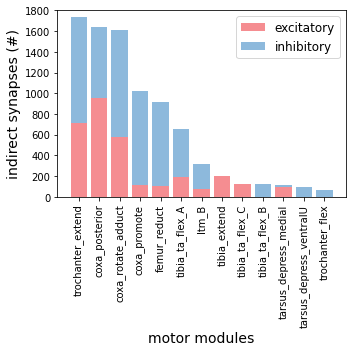

In [171]:
# stacked bar plot
fig = plt.figure(1, figsize=[5,5])
plt.bar(mm_names_sorted, ei_syns_sorted[0, :], color=(237/256, 28/256, 36/256, 0.5))
plt.bar(mm_names_sorted, ei_syns_sorted[1, :], bottom=ei_syns_sorted[0, :], color=(28/256, 117/256, 188/256, 0.5))
plt.xticks(rotation=90)
plt.ylim([0,1800])
plt.xlabel('motor modules', fontsize=14)
plt.ylabel('indirect synapses (#)', fontsize=14)
plt.legend(['excitatory', 'inhibitory'], fontsize=12)
plt.tight_layout()
plt.show()

fig.savefig(save_dir.joinpath('cxhp8_indirect_motor_inputs.png'))
fig.savefig(save_dir.joinpath('cxhp8_indirect_motor_inputs.pdf'))

### Motor impact scores - 2 hop network

In [31]:
# extract out motor module connectivity matrix
hp_premotor_mat = downstream_connectivity_matrix[:, cat_in_ids]   # set rows to all for premotor connectivity of every hp
premotor_ids = np.array(downstream_ids)[cat_in_ids]
premotor_sign = np.ones(len(premotor_ids))
premotor_sign[len(ein_id_order)::] = -1  # -1 sign for all inhibitory interneurons

In [32]:
# Query connectivity
interneuron_input_df = client.materialize.synapse_query(post_ids=premotor_ids)  # query the number of input synapses
neuropil_table = client.materialize.query_table('leg_mn_neuropil_reftable_v0')

In [33]:
# Motor module matrix for all hair plates (collapse for each motor module)
t1l_mns = module_table[neuropil_table['tag'] == 'left_t1']
# mms = np.unique(t1l_mns['tag'])  # motor module names -- unsorted
mms = ['coxa_rotate_adduct','coxa_promote', 'coxa_posterior', 
 'trochanter_flex', 'trochanter_extend', 'femur_reduct', 
 'tibia_ta_flex_A', 'tibia_ta_flex_B', 'tibia_ta_flex_C', 
 'tibia_extend','tarsus_depress_medial', 'tarsus_depress_ventralU',
 'ltm_A', 'ltm_B']
tot_mm_inputs = np.zeros(len(mms))
for i, mm in enumerate(mms):
    curr_mm_ids = t1l_mns['pt_root_id'][t1l_mns['tag'] == mm].values.tolist()
    tot_mm_inputs[i] = len(client.materialize.synapse_query(post_ids=curr_mm_ids))

In [34]:
# hair plates onto motor modules
hp_mm_mat = np.zeros((len(Lhp_names), len(mms)))
for j, hp in enumerate(Lhp_names):
    for i, mm in enumerate(mms):
        if mm in mm_name_store.tolist():
            mm_idxs = np.where(np.array(mm_name_store) == mm)[0]
            hp_mm_mat[j, i] = np.sum(downstream_connectivity_matrix[j, id_order[mm_idxs]])/tot_mm_inputs[i]

In [35]:
# Premotor matrix for all hair plates
hp_premotor_mat = downstream_connectivity_matrix[:, cat_in_ids]   # set rows to all for premotor connectivity of every hp
premotor_ids = np.array(downstream_ids)[cat_in_ids]
premotor_sign = np.ones(len(premotor_ids))
premotor_sign[len(ein_id_order)::] = -1  # -1 sign for all inhibitory interneurons
tot_premotor_inputs = interneuron_input_df.groupby('post_pt_root_id')['post_pt_root_id'].count().reset_index(name="number_of_synapses")
for i, segid in enumerate(premotor_ids):
    tot_synapses = tot_premotor_inputs['number_of_synapses'][tot_premotor_inputs['post_pt_root_id'] == segid].values[0]
    hp_premotor_mat[:, i] = hp_premotor_mat[:, i]/tot_synapses

In [36]:
# Premotor to module matrix
in_mm_mat = np.zeros((len(premotor_ids), len(mms)))
for j, premotor_id in enumerate(premotor_ids):
    interneuron_output_df = client.materialize.synapse_query(pre_ids=premotor_ids[j])
    dwn_synapses = interneuron_output_df.groupby(['post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
    dwn_synapses = dwn_synapses[dwn_synapses['number_of_synapses'] > syn_threshold]
    dwn_ids = dwn_synapses['post_pt_root_id'].values
    n_synapes = dwn_synapses['number_of_synapses'].values
    
    # check for motor module input
    for i, mm in enumerate(mms):
        curr_mm_ids = t1l_mns['pt_root_id'][t1l_mns['tag'] == mm].values.tolist()
        cum_syn = 0
        for k, mn_id in enumerate(curr_mm_ids):
            if mn_id in dwn_ids:
                cum_syn += n_synapes[np.where(mn_id == dwn_ids)[0]]
        
        # fractional input of interneuron onto motor module
        in_mm_mat[j, i] = premotor_sign[j] * (cum_syn/tot_mm_inputs[i])
    

In [42]:
# compute motor impact score
mean_motor_impact = np.zeros((len(hps), len(mms)))
for j, hp in enumerate(hps):
    hp_idxs = np.where(np.array(Lhp_names) == hp)[0]
    
    for i, mm in enumerate(mms):
        # Direct
        direct_synapes = np.mean(hp_mm_mat[hp_idxs[0]:hp_idxs[-1]+1, i])
        
        # Indirect
        indirect_synapses = np.mean(np.sum(hp_premotor_mat[hp_idxs[0]:hp_idxs[-1]+1, :] * in_mm_mat[:, i], axis=1))
        
        # Motor impact
        mean_motor_impact[j, i] = direct_synapes + indirect_synapses
        

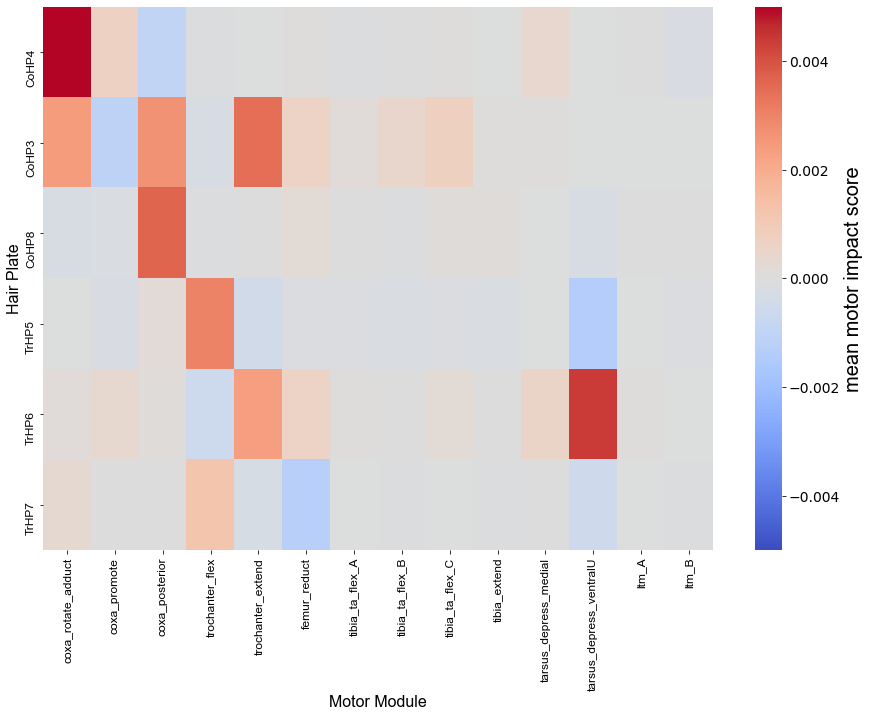

In [45]:
# plot motor impact
# visualize connectivity matrix
fig = plt.figure(1, figsize = [15,10])
ax = sea.heatmap(mean_motor_impact, xticklabels=mms, yticklabels=hps.tolist(), cmap='coolwarm',vmin=-0.005, vmax=0.005) # ,vmin=0, vmax=40
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'mean motor impact score', size=20, fontname ='Arial')
plt.xlabel('Motor Module', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.show()

fig.savefig(save_dir.joinpath('04132025_motor_impact_score.png'), dpi = 300, bbox_inches = 'tight')
fig.savefig(save_dir.joinpath('04132025_motor_impact_score.pdf'), dpi = 300, bbox_inches = 'tight')

### connectivity matrix of local premotor, local non-premotor, intersegmental, leg motor neurons, ascending, descending, sensory neurons 

In [19]:
# create color map
from matplotlib.colors import LinearSegmentedColormap
# 0.0, 0.0, 0.0 # black background == 0 synapses
# 1,1,1: white background
cm_data = [[1.0, 1.0, 1.0],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [20]:
# Hierarchical clustering of similarity matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    plt.close()
    
    return clustered_order

In [21]:
downstream_ids = np.array(downstream_ids)[np.array(downstream_cell_class)!='unknown'].tolist()
downstream_hemilineage = np.array(downstream_hemilineage)[np.array(downstream_cell_class)!='unknown'].tolist()
downstream_EI = np.array(downstream_EI)[np.array(downstream_cell_class)!='unknown'].tolist()
downstream_connectivity_matrix = downstream_connectivity_matrix[:,np.array(downstream_cell_class)!='unknown']
downstream_cell_class

['orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'orphan fragment',
 'intersegmental',
 'local',
 'orphan fragment',
 'leg motor neuron',
 'orphan fragment',
 'descending',
 'intersegmental',
 'local',
 'orphan fragment',
 'orphan fragment',
 'intersegmental',
 'local',
 'glia',
 'intersegmental',
 'intersegmental',
 'orphan fragment',
 'sensory neuron',
 'local',
 'sensory neuron',
 'intersegmental',
 'local',
 'sensory neuron',
 'ascending',
 'sensory neuron',
 'ascending',
 'local',
 'local',
 'ascending',
 'local',
 'g

In [59]:
# reorder connectivity matrix so that CxHP4 comes before CxHP3
swap_idx = np.arange(downstream_connectivity_matrix.shape[0])
swap_idx[0:4] = np.array([3,4,5,6])
swap_idx[4:7] = np.array([0,1,2])
downstream_connectivity_matrix = downstream_connectivity_matrix[swap_idx,:] # reorder so that CxHP4 comes first

In [32]:
# iterate through cell classes and perform agglomartive clustering
cell_classes = ['leg motor neuron', 'local premotor', 'local','intersegmental', 'ascending','descending', 'sensory neuron']
n_Neurons = np.zeros(len(cell_classes))
cnt = -1
store_mat = []
for j in cell_classes:
    cnt+=1
    class_idxs = np.where(np.array(downstream_cell_class) == j)[0]
    
    # isolate that part of the connectivity matrix
    filt_con_mat = downstream_connectivity_matrix[:,class_idxs]
    
    # cosine similarity to find structure
    sim_mat_2 = cosine_similarity(np.transpose(filt_con_mat))
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat_2)
    clustered_order_2 = plot_dendrogram(model, truncate_mode="level", p=filt_con_mat.shape[1]) # p truncate mode
    clustered_order_2 = np.array(clustered_order_2).astype(int) # convert strins into integers

    # reorder hairplate and motor neuron matrix
    reordered_mat = filt_con_mat[:, clustered_order_2]
    
    n_Neurons[cnt] = reordered_mat.shape[1]
    store_mat.append(reordered_mat)
    
    # horizontally stack arrays
    if cnt == 0:
        whole_mat = reordered_mat
    else:
        whole_mat = np.hstack ((whole_mat, reordered_mat))
    

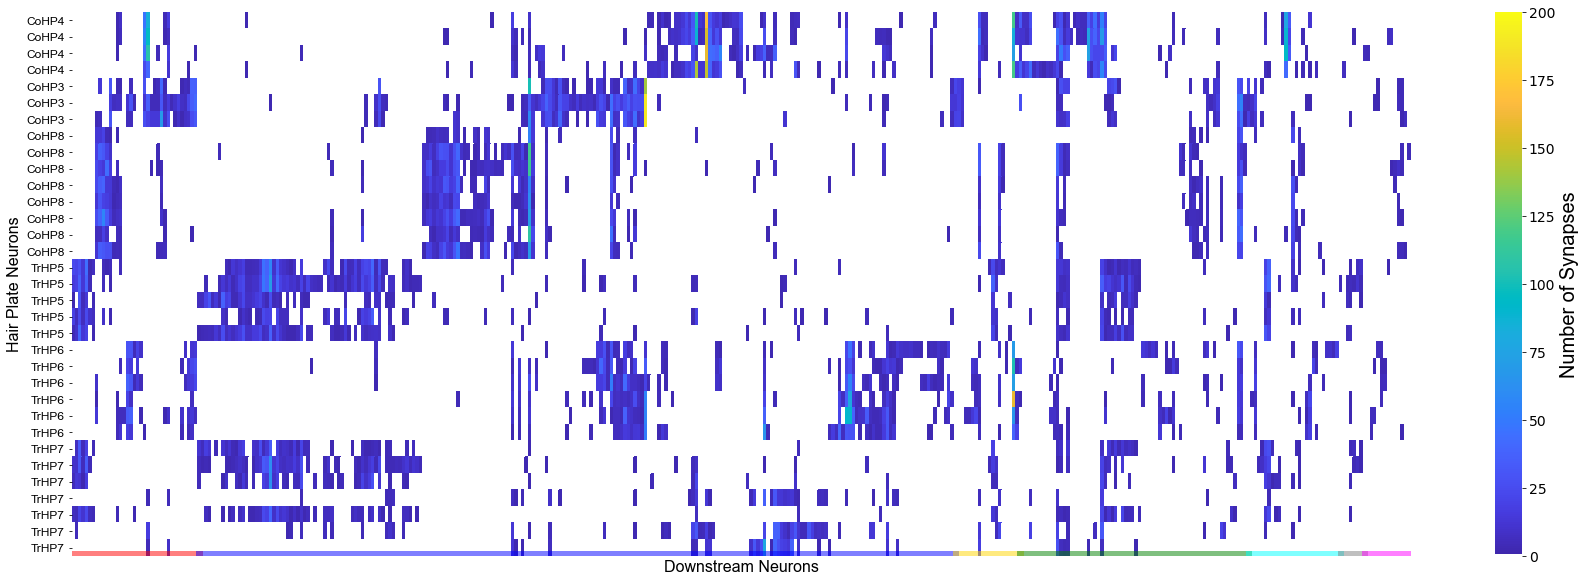

In [33]:
# visualize connectivity matrix
cat_colors = ['red', 'blue', 'gold', 'green', 'cyan','gray', 'magenta']
fig = plt.figure(1, figsize = [30,10])
ax = sea.heatmap(whole_mat, yticklabels=np.array(Lhp_names)[swap_idx].tolist(), cmap=parula_map,vmin=0, vmax=200) # yticklabels=np.array(Lhp_names)[clustered_order_1].tolist()
cbar = ax.collections[0].colorbar
# iterate and plot
st = 0
for i in range(len(n_Neurons)):
    ei = st+n_Neurons[i]
    plt.plot(np.array([st, ei]), np.array([33, 33]), color = cat_colors[i], alpha = 0.5, linewidth =10)
    st = ei+1

cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Downstream Neurons', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks([])
plt.show()
# fig.savefig(save_path+'hp_mn_connectivity_matrix.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_path+'hp_mn_connectivity_matrix.svg', dpi = 300, bbox_inches = 'tight')

### Motor module connections

In [18]:
# sort motor modules (~MNs) along the proximal-distal axis of the leg

'''Lines are commented below because it is already done'''
# mm_order = ['coxa_posterior', 'coxa_promotion', 'coxa_rotator_adductor', 'trochanter_flex', 
#            'trochanter_extend', 'femur_reduct', 'tibia_ta_flex_A', 'tibia_ta_flex_B', 'tibia_ta_flex_C',
#            'tibia_extend', 'tarsus_depressor_ventralU']
# # mm_idxs = np.where(np.array(downstream_cell_class) == 'leg motor neuron')[0]
# mm_names = np.array(downstream_hemilineage)[mm_idxs]

for j in range(len(mm_order)):
    curr_mm_ids = np.where(np.array(downstream_hemilineage) == mm_order[j])[0]
    if len(curr_mm_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_mm_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers
    
        if j ==0:
            id_order = curr_mm_ids[clustered_order]
            mm_name_store = np.repeat(mm_order[j], len(curr_mm_ids))
        else:
            id_order = np.concatenate((id_order, curr_mm_ids[clustered_order]))
            mm_name_store = np.concatenate((mm_name_store, np.repeat(mm_order[j], len(curr_mm_ids))))
    else:
        if j ==0:
            id_order = curr_mm_ids
            mm_name_store = np.repeat(mm_order[j], len(curr_mm_ids))
        else:
            id_order = np.concatenate((id_order, curr_mm_ids))
            mm_name_store = np.concatenate((mm_name_store, np.repeat(mm_order[j], len(curr_mm_ids))))

In [ ]:
# visualize connectivity matrix
# reorder connectivity matrix so that CxHP4 comes before CxHP3
swap_idx = np.arange(downstream_connectivity_matrix.shape[0])
swap_idx[0:4] = np.array([3,4,5,6])
swap_idx[4:7] = np.array([0,1,2])
swapped_downstream_connectivity_matrix = downstream_connectivity_matrix[swap_idx,:] # reorder so that CxHP4 comes first

# filter the hair plate to motor module
swapped_mm_mat = swapped_downstream_connectivity_matrix[:, id_order]

fig = plt.figure(1, figsize = [15,10])
ax = sea.heatmap(mm_mat_filt, xticklabels=filt_mm_name.tolist(), yticklabels=np.array(Lhp_names)[swap_idx].tolist(), cmap='Greys', vmin=0, vmax=40) #parula_map 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Motor Module', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.show()
# fig.savefig(save_dir.joinpath('03302025_hp_motor_module_connectivity_matrix.png'), dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_dir.joinpath('03302025_hp_motor_module_connectivity_matrix.pdf'), dpi = 300, bbox_inches = 'tight')

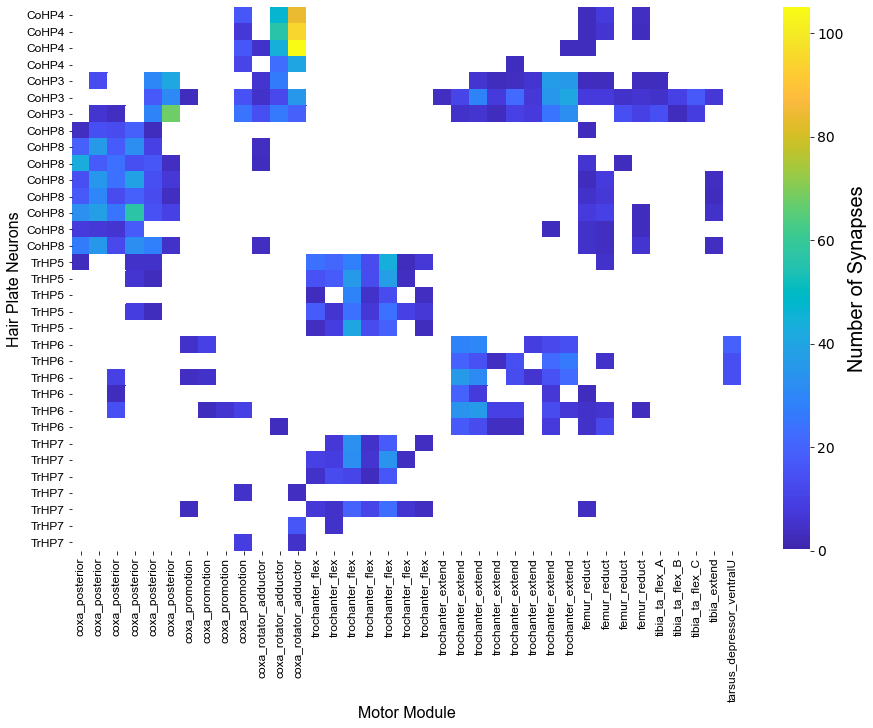

In [203]:
# extract out motor module connectivity matrix
mm_mat = downstream_connectivity_matrix[:, id_order]

# visualize connectivity matrix
fig = plt.figure(1, figsize = [15,10])
ax = sea.heatmap(mm_mat, xticklabels=mm_name_store.tolist(), yticklabels=np.array(Lhp_names)[swap_idx].tolist(), cmap=parula_map,vmin=0, vmax=105) # 
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Motor Module', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.show()
fig.savefig(save_path+'motor_module_connectivity_matrix.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(save_path+'motor_module_connectivity_matrix.svg', dpi = 300, bbox_inches = 'tight')

### IIN premotor neurons

In [34]:
# seperate inhibitory and excitatory premotor neurons
syn_threshold = 20
# inhibitory
iin_order = ['6A', '8A', '9A', '12B', '13A', '13B', '14A', '16B', '19A', '21A']
iin_pre_idxs = np.where(np.logical_and(np.array(downstream_cell_class) == 'local premotor', np.array(downstream_EI) == 'I') == True)[0]
iin_names = np.array(downstream_hemilineage)[iin_pre_idxs]

for j in range(len(iin_order)):
    curr_ids = iin_pre_idxs[np.where(np.array(iin_names) == iin_order[j])[0]]
    if len(curr_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers

        if j ==0:
            iin_id_order = curr_ids[clustered_order]
            iin_name_store = np.repeat(iin_order[j], len(curr_ids))
            cnt = 1
        else:
            iin_id_order = np.concatenate((iin_id_order, curr_ids[clustered_order]))
            iin_name_store = np.concatenate((iin_name_store, np.repeat(iin_order[j], len(curr_ids))))
    else:
        if j ==0:
            iin_id_order = curr_ids
            iin_name_store = np.repeat(iin_order[j], len(curr_ids))
            cnt = 1
        else:
            iin_id_order = np.concatenate((iin_id_order, curr_ids))
            iin_name_store = np.concatenate((iin_name_store, np.repeat(iin_order[j], len(curr_ids))))


# excitatory
ein_order = ['1A', '3A', '4B', '7B', '17A', '19B', '20A', '22A', '23B']
ein_pre_idxs = np.where(np.logical_and(np.array(downstream_cell_class) == 'local premotor', np.array(downstream_EI) == 'E') == True)[0]
ein_names = np.array(downstream_hemilineage)[ein_pre_idxs]
for j in range(len(ein_order)):
    curr_ids = ein_pre_idxs[np.where(np.array(ein_names) == ein_order[j])[0]]
    if len(curr_ids)>1:
        temp_mat = downstream_connectivity_matrix[:, curr_ids]
        # cosine similarity to find structure
        sim_mat = cosine_similarity(np.transpose(temp_mat))
        model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(sim_mat)
        clustered_order = plot_dendrogram(model, truncate_mode="level", p=temp_mat.shape[1]) # p truncate mode
        clustered_order = np.array(clustered_order).astype(int) # convert strins into integers

        if j ==0:
            ein_id_order = curr_ids[clustered_order]
            ein_name_store = np.repeat(ein_order[j], len(curr_ids))
            cnt = 1
        else:
            ein_id_order = np.concatenate((ein_id_order, curr_ids[clustered_order]))
            ein_name_store = np.concatenate((ein_name_store, np.repeat(ein_order[j], len(curr_ids))))
    else:
        if j ==0:
            ein_id_order = curr_ids
            ein_name_store = np.repeat(ein_order[j], len(curr_ids))
            cnt = 1
        else:
            ein_id_order = np.concatenate((ein_id_order, curr_ids))
            ein_name_store = np.concatenate((ein_name_store, np.repeat(ein_order[j], len(curr_ids))))

### CxHP8 premotor connectivity

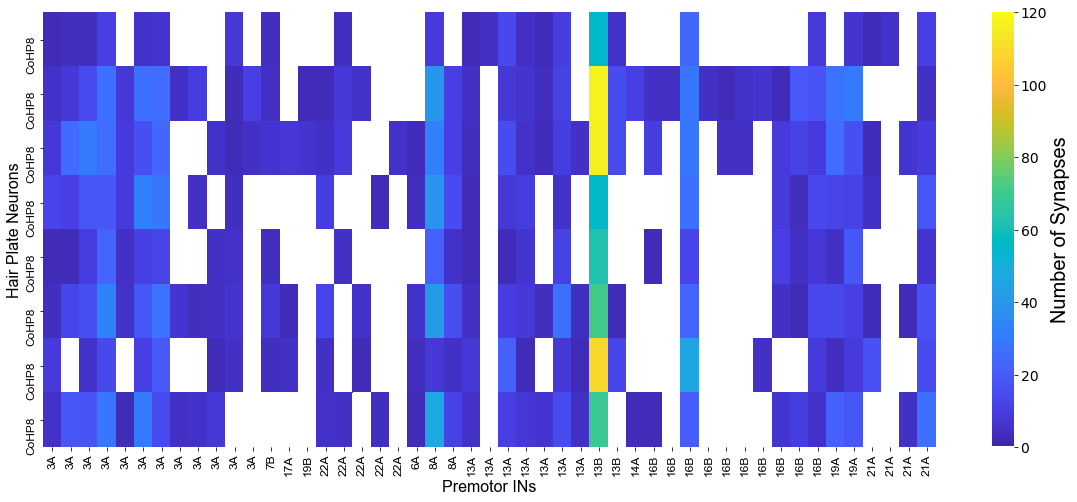

In [59]:
# combine ein and iin matrices and visualize
cat_in_ids = np.concatenate((ein_id_order, iin_id_order))
cat_in_names = np.concatenate((ein_name_store, iin_name_store))

# extract out motor module connectivity matrix
in_mat = downstream_connectivity_matrix[7:15, cat_in_ids]

# filter matrix
synapse_threshold = 4
f_idxs = np.where(np.sum(in_mat, axis = 0) > synapse_threshold)[0]
f_premat = in_mat[:, f_idxs]

# visualize connectivity matrix
fig = plt.figure(1, figsize = [20,8])
ax = sea.heatmap(f_premat, xticklabels = cat_in_names[f_idxs].tolist(), yticklabels=np.array(Lhp_names)[7:15].tolist(), cmap=parula_map,vmin=0, vmax=120) #
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Premotor INs', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 12, fontname = 'Arial')
plt.show()
fig.savefig(save_path+'cxhp8_premotor_connectivity_matrix.png', dpi = 300, bbox_inches = 'tight')
fig.savefig(save_path+'cxhp8_premotor_connectivity_matrix.svg', dpi = 300, bbox_inches = 'tight')

### All hair-plates

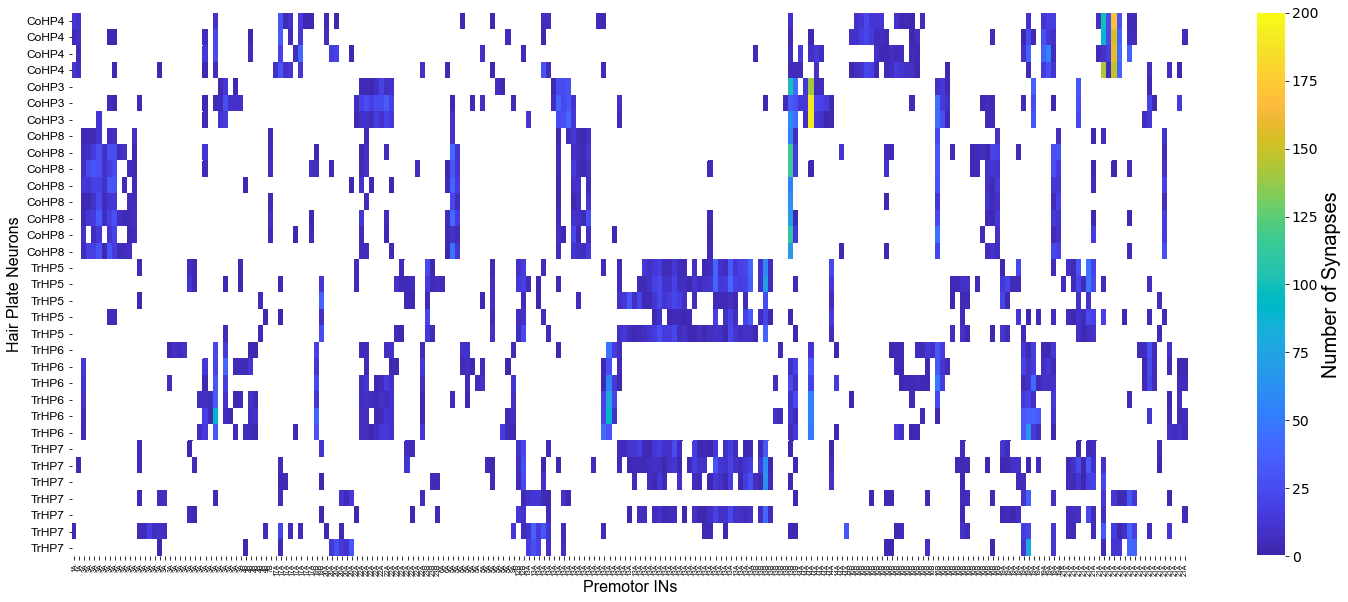

In [35]:
# combine ein and iin matrices and visualize
cat_in_ids = np.concatenate((ein_id_order, iin_id_order))
cat_in_names = np.concatenate((ein_name_store, iin_name_store))

# extract out motor module connectivity matrix
in_mat = downstream_connectivity_matrix[:, cat_in_ids]

# visualize connectivity matrix
fig = plt.figure(1, figsize = [25,10])
ax = sea.heatmap(in_mat, xticklabels = cat_in_names.tolist(), yticklabels=np.array(Lhp_names)[swap_idx].tolist(), cmap=parula_map,vmin=0, vmax=200) #
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
cbar.set_label(label = 'Number of Synapses', size=20, fontname ='Arial')
plt.xlabel('Premotor INs', fontsize =16, fontname ='Arial')
plt.ylabel('Hair Plate Neurons', fontsize =16, fontname ='Arial')
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.xticks(fontsize = 7, fontname = 'Arial')
plt.show()
# fig.savefig(save_path+'premotor_connectivity_matrix.png', dpi = 300, bbox_inches = 'tight')
# fig.savefig(save_path+'premotor_connectivity_matrix.svg', dpi = 300, bbox_inches = 'tight')